# Causal Abstraction Analysis with Distributed Alignment Search 

In [1]:
__author__ = "Atticus Geiger"

## Contents

1. [The hierarchical equality task](#The-hierarchical-equality-task)
    1. [An Algorithm that Solves the Equality Task](#An-Algorithm-that-Solves-the-Equality-Task)
        1. [The algorithm with no intervention](#The-algorithm-with-no-intervention)
        1. [The algorithm with an intervention](#The-algorithm-with-an-intervention)
        1. [The algorithm with an interchange intervention](#The-algorithm-with-an-interchange-intervention)
    1. [Hand Crafting an MLP to Solve Hierarchical Equality](#Hand-Crafting-an-MLP-to-Solve-Hierarchical-Equality)        
    1. [Training an MLP to Solve Hierarchical Equality](#Training-an-MLP-to-Solve-Hierarchical-Equality)
1. [Causal abstraction Analysis](#Causal-abstraction)
    1. [Basic intervention: zeroing out part of a hidden layer](#Basic-intervention:-zeroing-out-part-of-a-hidden-layer)
    1. [An interchange intervention](#An-interchange-intervention)
    1. [Alignment](#Alignment)
    1. [Evaluating an Alignment](#Evaluation)
1. [Interchange Intervention Training (IIT)](#Interchange-Intervention-Training-(IIT))
1. [Distributed Alignment Search (DAS)](#Distributed-Alignment-Search-(DAS))

## Set-up

This notebook is a hands-on introduction to __causal abstraction analysis__ using __distributed alignment search__ with neural networks.

In causal abstraction analysis, we assess whether trained models conform to high-level causal models that we specify, not just in terms of their input–output behavior, but also in terms of their internal dynamics. The core technique is the __interchange intervention__, in which a causal model is provided an input and then intermediate variables are fixed to take on the values they would have for a second input.

To motivate and illustrate these concepts, we're going to focus on a hierarchical equality task, building on work by [Geiger, Carstensen, Frank, and Potts (2020)](https://arxiv.org/abs/2006.07968).

In [2]:
import sys, os
sys.path.append(os.path.join('..', '..'))

In [3]:
import torch
from torch.utils.data import DataLoader
from datasets import Dataset
import random
import copy
import itertools
import numpy as np
from tqdm import tqdm, trange
from highlevel_models.causal_model import CausalModel
from sklearn.metrics import classification_report
from transformers import get_linear_schedule_with_warmup
from models.mlp.modelings_mlp import MLPConfig
from models.mlp.modelings_alignable_mlp import create_mlp_classifier
from models.configuration_alignable_model import AlignableRepresentationConfig, AlignableConfig
from models.interventions import VanillaIntervention, RotatedSpaceIntervention, LowRankRotatedSpaceIntervention
from models.alignable_base import AlignableModel

C:\Users\attic\anaconda3\envs\bigkid\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
seed = 42
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)

## The hierarchical equality task

This section builds on results presented in [Geiger, Carstensen, Frank, and Potts (2020)](https://arxiv.org/abs/2006.07968). We will use a hierarchical equality task ([Premack 1983](https://www.cambridge.org/core/services/aop-cambridge-core/content/view/7DF6F2D22838F7546AF7279679F3571D/S0140525X00015077a.pdf/div-class-title-the-codes-of-man-and-beasts-div.pdf)) to present interchange intervention training (IIT). 

We define the hierarchical equality task as follows: The input is two pairs of objects and the output is **True** if both pairs contain the same object or if both pairs contain different objects and **False** otherwise.  For example, `AABB` and `ABCD` are both labeled **True**, while `ABCC` and `BBCD` are both labeled **False**. 

## An Algorithm that Solves the Equality Task

Let $\mathcal{A}$ be the simple tree-structured algorithm that solves this task by applying a simple equality relation three times: Compute whether the first two inputs are equal, compute whether the second two inputs are equal, then compute whether the truth-valued outputs of these first two computations are equal. 

And here's a Python implementation of $\mathcal{A}$ that supports the interventions we'll want to do:

In [5]:

def randvec(n=50, lower=-1, upper=1):
    return np.array([round(random.uniform(lower, upper), 2) for i in range(n)])

embedding_dim = 2
number_of_entities = 1000

variables =  ["W", "X", "Y", "Z", "WX", "YZ", "O"]

reps = [randvec(embedding_dim, lower=-1, upper=1) for _ in range(number_of_entities)]
values = {variable:reps for variable in ["W","X", "Y", "Z"]}
values["WX"] = [True, False]
values["YZ"] = [True, False]
values["O"] = [True, False]

parents = {"W":[],"X":[], "Y":[], "Z":[], 
           "WX":["W", "X"], "YZ":["Y", "Z"], 
           "O":["WX", "YZ"]}

def FILLER():
    return reps[0]

functions = {"W":FILLER,"X":FILLER, "Y":FILLER, "Z":FILLER, 
             "WX": lambda x,y: np.array_equal(x,y), 
             "YZ":lambda x,y: np.array_equal(x,y), 
             "O": lambda x,y: x==y}

pos = {"W":(0.2,0),"X":(1,0.1), "Y":(2,0.2), "Z":(2.8,0), 
           "WX":(1,2), "YZ":(2,2), 
           "O":(1.5,3)}

equiv_classes = {}

equality_model = CausalModel(variables, values, parents, functions, pos = pos)

Here's a visual depiction of the algorithm:

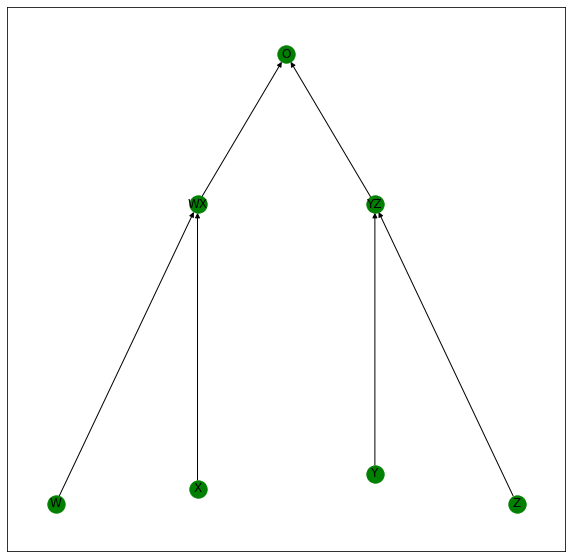

Timesteps: {'W': 0, 'X': 0, 'Y': 0, 'Z': 0, 'WX': 1, 'YZ': 1, 'O': 3}


In [6]:
equality_model.print_structure()
print("Timesteps:", equality_model.timesteps)

### The algorithm with no intervention

Let's first observe the behavior of the algorithm when we provide the input `BBCD` with no interventions. Here is a visual depiction:

No intervention:
 defaultdict(None, {'W': array([ 0.28, -0.95]), 'X': array([ 0.28, -0.95]), 'Y': array([-0.45, -0.55]), 'Z': array([ 0.78, -0.83]), 'WX': True, 'YZ': False, 'O': False}) 



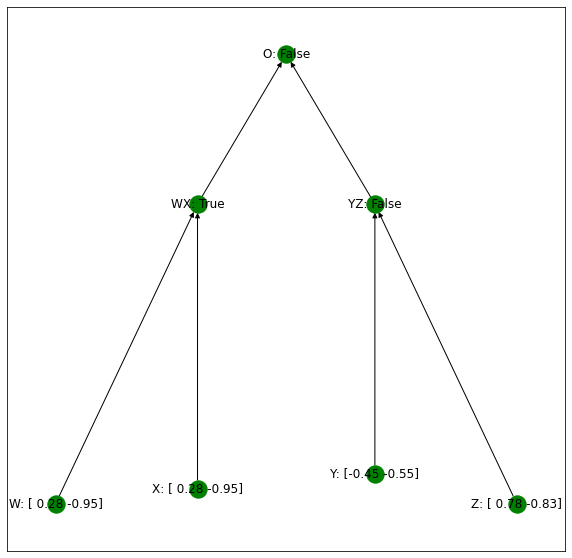

In [7]:
setting = equality_model.run_forward({"W":reps[0], "X":reps[0], "Y":reps[1], "Z":reps[3]})
print("No intervention:\n", setting, "\n")
equality_model.print_setting(setting)

### The algorithm with an intervention

Let's now see the behavior of the algorithm when we provide the input `BBCD` with an intervention setting **WX** to **False**. First, a visual depiction:

<img src="fig/IIT/PremackIntervention.png" width="500"/>

And then the same computation with `compute_A`:

Intervention setting WX to TRUE:



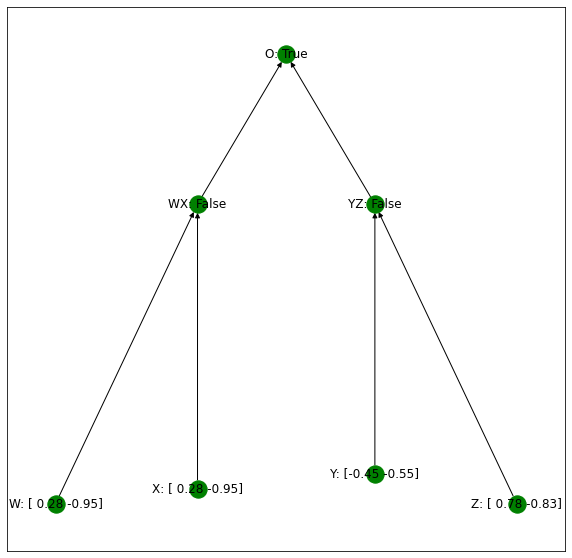

In [8]:
print("Intervention setting WX to TRUE:\n", )
equality_model.print_setting(equality_model.run_forward({"W":reps[0], "X":reps[0], "Y":reps[1], "Z":reps[3], "WX":False}))

Notice that, in this example, even though the left two inputs are not the same, the intervention has changed the intermediate prediction for those two inputs from **False** to **True**, and thus the algorithm outputs **True**, since its output is determined by **WX** and **YZ**.

### The algorithm with an interchange intervention

Finally, let's observe the behavior of the algorithm when we provide the base input `BBCD` with an intervention setting **WX** to be the value it would be for the source input `ABCC`.

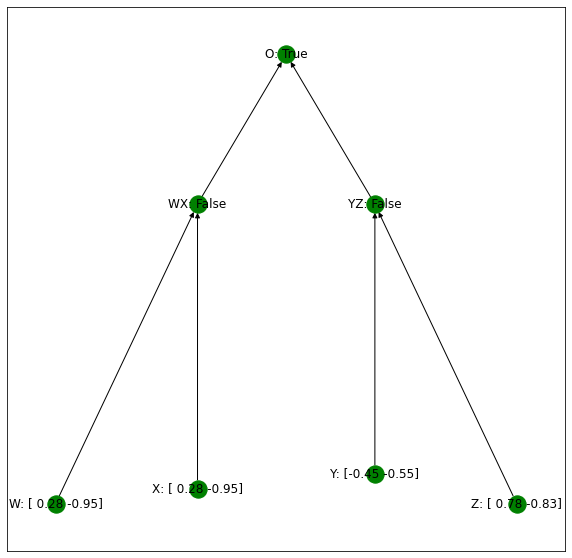

In [9]:
base = {"W":reps[0], "X":reps[0], "Y":reps[1], "Z":reps[3]}
source = {"W":reps[0], "X":reps[1], "Y":reps[2], "Z":reps[2]}
setting = equality_model.run_interchange(base, {"WX":source})
equality_model.print_setting(setting)

# Hand Crafting an MLP to Solve Hierarchical Equality

In [10]:
n_examples = 2048

X, y = equality_model.generate_factual_dataset(n_examples,equality_model.sample_input_tree_balanced)

X = X.unsqueeze(1)

In [11]:
config = MLPConfig(h_dim=embedding_dim*4,
          activation_function = "relu",
          n_layer = 2,
          n_labels = 2,
          pdrop = 0.0)

In [12]:
config, tokenizer, handcrafted = create_mlp_classifier(config)

loaded model


The first layer of our handcrafted model computes:

$ReLU(W_1[\mathbf{a}, \mathbf{b}, \mathbf{c}, \mathbf{d}]) = [max(\mathbf{a}-\mathbf{b}, 0), max(\mathbf{b}-\mathbf{a}, 0), max(\mathbf{c}-\mathbf{d}, 0), max(\mathbf{d}-\mathbf{c}, 0)]$


In [13]:
W1 = [[ 1,  0, -1,  0,  0,  0,  0,  0],
      [ 0,  1,  0, -1,  0,  0,  0,  0],
      [-1,  0,  1,  0,  0,  0,  0,  0],
      [ 0, -1,  0,  1,  0,  0,  0,  0],
      [ 0,  0,  0,  0,  1,  0, -1,  0],
      [ 0,  0,  0,  0,  0,  1,  0, -1],
      [ 0,  0,  0,  0, -1,  0,  1,  0],
      [ 0,  0,  0,  0,  0, -1,  0,  1]]
handcrafted.mlp.h[0].ff1.weight = torch.nn.Parameter(torch.FloatTensor(W1))
handcrafted.mlp.h[0].ff1.bias = torch.nn.Parameter(torch.FloatTensor([0,0,0,0,0,0,0,0]))
handcrafted.mlp.h[0].ff2.weight = torch.nn.Parameter(torch.eye(embedding_dim*4))
handcrafted.mlp.h[0].ff2.bias = torch.nn.Parameter(torch.FloatTensor([0,0,0,0,0,0,0,0]))

The second layer of our handcrafted model computes:

$ReLU(W_2ReLU(W_1[\mathbf{a}, \mathbf{b}, \mathbf{c}, \mathbf{d}])) = [|\mathbf{a}-\mathbf{b}| - |\mathbf{c}-\mathbf{d}|, |\mathbf{c}-\mathbf{d}|-|\mathbf{a}-\mathbf{b}|, |\mathbf{a}-\mathbf{b}|, |\mathbf{c}-\mathbf{d}|,0,0,0,0]$


In [14]:
W2 = [[ 1,-1, 0, 1, 0, 0, 0, 0],
      [ 1,-1, 0, 1, 0, 0, 0, 0],
      [ 1,-1, 0, 1, 0, 0, 0, 0],
      [ 1,-1, 0, 1, 0, 0, 0, 0],
      [-1, 1, 1, 0, 0, 0, 0, 0],
      [-1, 1, 1, 0, 0, 0, 0, 0],
      [-1, 1, 1, 0, 0, 0, 0, 0],
      [-1, 1, 1, 0, 0, 0, 0, 0]]
handcrafted.mlp.h[1].ff1.weight = torch.nn.Parameter(torch.FloatTensor(W2).transpose(0,1))
handcrafted.mlp.h[1].ff1.bias = torch.nn.Parameter(torch.FloatTensor([0,0,0,0,0,0,0,0]))
handcrafted.mlp.h[1].ff2.weight = torch.nn.Parameter(torch.eye(embedding_dim*4))
handcrafted.mlp.h[1].ff2.bias = torch.nn.Parameter(torch.FloatTensor([0,0,0,0,0,0,0,0]))

The third layer of our handcrafted model computes the logits:

$W_3 ReLU(W_2ReLU(W_1[\mathbf{a}, \mathbf{b}, \mathbf{c}, \mathbf{d}])) = [||\mathbf{a}-\mathbf{b}| - |\mathbf{c}-\mathbf{d}|| -0.999999|\mathbf{a}-\mathbf{b}|-0.999999|\mathbf{c}-\mathbf{d}|, 0]$

In [15]:
W3 = [[        1, 0],
      [        1, 0],
      [-0.999999, 0],
      [-0.999999, 0],
      [        0, 0],
      [        0, 0],
      [        0, 0],
      [        0, 0]]
handcrafted.score.weight = torch.nn.Parameter(torch.FloatTensor(W3).transpose(0,1))
handcrafted.score.bias = torch.nn.Parameter(torch.FloatTensor([0,0.00000000000001]))

In [16]:
preds = handcrafted.forward(inputs_embeds=X)

print("Train Results")
print(classification_report(y, preds[0].argmax(1)))

Train Results
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1037
         1.0       1.00      1.00      1.00      1011

    accuracy                           1.00      2048
   macro avg       1.00      1.00      1.00      2048
weighted avg       1.00      1.00      1.00      2048



# Causal abstraction

The formal theory of **causal abstraction** describes the conditions that must hold for the high-level tree structured algorithm to be a **simplified and faithful description** of the neural network. 

In essence: an high-level model is a causal abstraction of a neural network if and only if for all base and source inputs, the algorithm and network provides the same output, for some alignment between these two models.

Below, we define an alignment between the neural network and the algorithm and a function to compute the **interchange intervention accuracy** (II accuracy) for a high-level variable: the percentage of aligned interchange interventions that the network and algorithm produce the same output on. When the II accuracy is 100%, the causal abstraction relation holds between the network and a simplified version of the algorithm where only one high-level variable exists.

In [17]:
alignable_config = AlignableConfig(
        alignable_model_type=type(handcrafted),
        alignable_representations=[
            AlignableRepresentationConfig(
                0,             # layer
                "block_output", # intervention type
                "pos",             # intervention unit
                1,                  # max number of unit
                subspace_partition = [[0,4],[4,8]],
             intervention_link_key=0 # create sym link across interventions
            ),
            AlignableRepresentationConfig(
                0,             # layer
                "block_output", # intervention type
                "pos",             # intervention unit
                1,                  # max number of unit
                subspace_partition = [[0,4],[4,8]],
             intervention_link_key=0 # create sym link across interventions
            ),
        ],
        alignable_interventions_type=VanillaIntervention,
    )
alignable_handcrafted = AlignableModel(alignable_config, handcrafted)

Next we create a counterfactual equality dataset that includes interchange intervention examples:

In [18]:
def intervention_id(intervention):
    if "WX" in intervention and "YZ" in intervention:
        return 2
    if "WX" in intervention:
        return 0
    if "YZ" in intervention:
        return 1

In [19]:
data_size = 2048
batch_size = 16
dataset = equality_model.generate_counterfactual_dataset(data_size,
                                                        intervention_id,
                                                        batch_size,
                                                        device = "cuda:0",
                                                        sampler=equality_model.sample_input_tree_balanced)

In [20]:
print(dataset[0]["input_ids"])
print(dataset[0]["source_input_ids"])
print(dataset[0]["labels"])
print(dataset[0]["base_labels"])
print(dataset[0]["intervention_id"])

tensor([-0.1600, -0.9400,  0.9900, -0.2400, -0.8000,  0.5400, -0.8000,  0.5400],
       device='cuda:0')
tensor([[ 0.3600, -0.9400,  0.6300, -0.5300,  0.3400,  0.7200,  0.3400,  0.7200],
        [-0.7900,  0.1100, -0.7900,  0.1100, -0.3800, -0.1000, -0.3800, -0.1000]],
       device='cuda:0')
tensor([0.], device='cuda:0')
tensor([0.], device='cuda:0')
tensor([2], device='cuda:0')


In [21]:
print(dataset[1]["input_ids"])
print(dataset[1]["source_input_ids"])
print(dataset[1]["labels"])
print(dataset[1]["base_labels"])
print(dataset[1]["intervention_id"])

tensor([-0.7900, -0.1500,  0.3600,  0.0700, -0.8000,  0.2700, -0.7800,  0.0100],
       device='cuda:0')
tensor([[ 0.8400,  0.0200,  0.9600,  0.1700, -0.4000, -0.4200,  0.0600,  0.8300],
        [-0.3600, -0.0500, -0.6300,  0.4700,  0.1100,  0.5800,  0.1100,  0.5800]],
       device='cuda:0')
tensor([0.], device='cuda:0')
tensor([1.], device='cuda:0')
tensor([2], device='cuda:0')


This dataset has the following components:

* `X_base_train`: a regular set of train examples
* `y_base_train`: a regular set of train labels
* `X_sources_train`: a list additional train sets (here, a singleton list of them) for counterfactuals
* `y_IIT_train`: a list of labels for the examples in `X_sources_train`.
* `interventions`: a list of intervention sites (here, all `0` corresponding to our key for "V1")

In [22]:
handcrafted.to("cuda:0")
for parameter in alignable_handcrafted.get_trainable_parameters():
    parameter.to("cuda:0")
preds = []
for batch in DataLoader(dataset, batch_size):
    batch["input_ids"] = batch["input_ids"].unsqueeze(1)    
    batch["source_input_ids"] = batch["source_input_ids"].unsqueeze(2)    
    if batch["intervention_id"][0] == 2:
        _, counterfactual_outputs = alignable_handcrafted(
                {"inputs_embeds":batch["input_ids"]},
                [{"inputs_embeds":batch["source_input_ids"][:, 0]}, 
                 {"inputs_embeds":batch["source_input_ids"][:,1]}],
                {"sources->base": ([[[0]]*batch_size, [[0]]*batch_size], [[[0]]*batch_size, [[0]]*batch_size])},
            subspaces=[[[0]]*batch_size, [[1]]*batch_size]
            )
    elif batch["intervention_id"][0] == 0:
        _, counterfactual_outputs = alignable_handcrafted(
                {"inputs_embeds":batch["input_ids"]},
                [{"inputs_embeds":batch["source_input_ids"][:,0]}, None],
                {"sources->base": ([[[0]]*batch_size, None], [[[0]]*batch_size, None])},
                subspaces=[[[0]]*batch_size, None]
            )
    elif batch["intervention_id"][0] == 1:
        _, counterfactual_outputs = alignable_handcrafted(
                {"inputs_embeds":batch["input_ids"]},
                [None, {"inputs_embeds":batch["source_input_ids"][:,0]}],
                {"sources->base": ([None, [[0]]*batch_size], [None, [[0]]*batch_size])},
                subspaces=[None, [[1]]*batch_size]
            )
    preds.append(counterfactual_outputs[0])

In [23]:
preds = torch.cat(preds)

In [24]:
print(classification_report(torch.tensor([x["labels"] for x in dataset]).cpu(), preds.argmax(1).cpu()))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1021
         1.0       1.00      1.00      1.00      1027

    accuracy                           1.00      2048
   macro avg       1.00      1.00      1.00      2048
weighted avg       1.00      1.00      1.00      2048



# Training an MLP to Solve Hierarchical Equality

We've now seen how interventions work in our high-level causal model. We turn now to doing parallel work in our neural network, which will be a fully-connected feed-forward neural network with three hidden layers. The following code simply extends `TorchDeepNeuralClassifier` with a method `retrieve_activations` that supports interventions on PyTorch computation graphs:

The module `iit` provides some dataset functions for equality learning. Here we define a simple an equality dataset:

In [25]:

def randvec(n=50, lower=-1, upper=1):
    return np.array([random.uniform(lower, upper) for i in range(n)])
embedding_dim = 4
number_of_entities = 1000

variables =  ["W", "X", "Y", "Z", "WX", "YZ", "O"]

reps = [randvec(embedding_dim, lower=-1, upper=1) for _ in range(number_of_entities)]
values = {variable:reps for variable in ["W","X", "Y", "Z"]}
values["WX"] = [True, False]
values["YZ"] = [True, False]
values["O"] = [True, False]

parents = {"W":[],"X":[], "Y":[], "Z":[], 
           "WX":["W", "X"], "YZ":["Y", "Z"], 
           "O":["WX", "YZ"]}

def FILLER():
    return reps[0]

functions = {"W":FILLER,"X":FILLER, "Y":FILLER, "Z":FILLER, 
             "WX": lambda x,y: np.array_equal(x,y), 
             "YZ":lambda x,y: np.array_equal(x,y), 
             "O": lambda x,y: x==y}

pos = {"W":(0.2,0),"X":(1,0.1), "Y":(2,0.2), "Z":(2.8,0), 
           "WX":(1,2), "YZ":(2,2), 
           "O":(1.5,3)}

equiv_classes = {}

equality_model = CausalModel(variables, values, parents, functions, pos = pos)

In [26]:
n_examples = 1048576
batch_size = 1024

X, y = equality_model.generate_factual_dataset(n_examples,equality_model.sample_input_tree_balanced)

X = X.unsqueeze(1)

The examples in this dataset are 8-dimensional vectors: the concatenation of 4 2-dimensional vectors. Here's the first example with its label:

In [27]:
X[0], y[0]

(tensor([[ 0.5750, -0.4304, -0.5277, -0.0286,  0.5750, -0.4304, -0.5277, -0.0286,
          -0.9404,  0.4808,  0.4881, -0.3107, -0.9404,  0.4808,  0.4881, -0.3107]]),
 tensor([1.]))

The label for this example is determined by whether the equality value for the first two inputs matches the equality value for the second two inputs:

In [28]:
left = torch.equal(
    X[0][: embedding_dim],
    X[0][embedding_dim: embedding_dim*2])

left

False

In [29]:
right = torch.equal(
    X[0][embedding_dim*2: embedding_dim*3],
    X[0][embedding_dim*3: ])

right

True

In [30]:
int(left == right)

0

Let's see how our model does out-of-the-box on this task:

In [31]:
config = MLPConfig(h_dim=embedding_dim*4,
          activation_function = "relu",
          n_layer = 3,
          n_labels = 2,
          pdrop = 0.0
         )

In [32]:
config, tokenizer, trained = create_mlp_classifier(config)

loaded model


In [33]:
trained.train()

MLPForClassification(
  (mlp): MLPModel(
    (dropout): Dropout(p=0.0, inplace=False)
    (h): ModuleList(
      (0-2): 3 x MLPBlock(
        (ff1): Linear(in_features=16, out_features=16, bias=True)
        (act): ReLU()
        (ff2): Linear(in_features=16, out_features=16, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
    )
  )
  (score): Linear(in_features=16, out_features=2, bias=True)
)

In [34]:
train_ds = Dataset.from_dict({
    "labels":[torch.FloatTensor([0,1]) if i == 1 else torch.FloatTensor([1,0]) for i in y],
    "inputs_embeds":X})

In [35]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
                output_dir="test_trainer", 
                evaluation_strategy="epoch",
                learning_rate=0.0001,
                num_train_epochs=24,
                per_device_train_batch_size=batch_size,
                per_device_eval_batch_size=batch_size
                )

trainer = Trainer(
    model=trained,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=train_ds,
    compute_metrics=lambda x: {"accuracy":classification_report(x[0].argmax(1),x[1].argmax(1), output_dict=True)["accuracy"]},
)

In [36]:

_ = trainer.train()

Could not estimate the number of tokens of the input, floating-point operations will not be computed


Epoch,Training Loss,Validation Loss,Accuracy
1,0.693100,0.693104,0.512734
2,0.674700,0.622937,0.678976
3,0.428500,0.378837,0.829169
4,0.248600,0.171913,0.935514
5,0.052300,0.027131,0.992693
6,0.012900,0.009009,0.997626
7,0.006100,0.004950,0.998678
8,0.003800,0.003151,0.999101
9,0.002500,0.002175,0.999506
10,0.001900,0.001529,0.999600


This neural network achieves near perfect performance on its train set:

And it generalizes perfectly to a test set consisting of distinct vectors:

In [37]:
variables =  ["W", "X", "Y", "Z", "WX", "YZ", "O"]

number_of_test_entities = 1000

reps = [randvec(embedding_dim)  for _ in range(number_of_test_entities)]
values = {variable:reps for variable in ["W","X", "Y", "Z"]}
values["WX"] = [True, False]
values["YZ"] = [True, False]
values["O"] = [True, False]

parents = {"W":[],"X":[], "Y":[], "Z":[], 
           "WX":["W", "X"], "YZ":["Y", "Z"], 
           "O":["WX", "YZ"]}

def FILLER():
    return reps[0]

functions = {"W":FILLER,"X":FILLER, "Y":FILLER, "Z":FILLER, 
             "WX": lambda x,y: np.array_equal(x,y), "YZ":lambda x,y: np.array_equal(x,y), 
             "O": lambda x,y: x==y}

pos = {"W":(0,0),"X":(1,0.1), "Y":(2,0.2), "Z":(3,0), 
           "WX":(1,2), "YZ":(2,2), 
           "O":(1.5,3)}

test_equality_model = CausalModel(variables, values, parents, functions, pos = pos)

In [38]:
X_test, y_test = test_equality_model.generate_factual_dataset(10000,equality_model.sample_input_tree_balanced)
print("Test Results")

test_ds = Dataset.from_dict({
    "labels":[torch.FloatTensor([0,1]) if i == 1 else torch.FloatTensor([1,0]) for i in y_test],
    "inputs_embeds":X_test})

test_preds = trainer.predict(test_ds)

print(classification_report(y_test, test_preds[0].argmax(1)))

Test Results


              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      4925
         1.0       1.00      1.00      1.00      5075

    accuracy                           1.00     10000
   macro avg       1.00      1.00      1.00     10000
weighted avg       1.00      1.00      1.00     10000



Does it implement our high-level model of the problem, though?

# Distributed Alignment Search

Interchange Intervention Training (IIT) is a method for training a neural network to conform to the causal structure of a high-level algorithm. Conceptually, it is a direct extension of the causal abstraction analysis we just performed, except instead of **evaluating** whether the neural network and algorithm produce the same outputs under aligned interchange interventions, we are now **training** the neural network to produce the output of the algorithm under aligned interchange interventions.

IIT was developed by [Geiger\*, Wu\*, Lu\*, Rozner, Kreiss, Icard, Goodman, and Potts (2021)](https://arxiv.org/abs/2112.00826), and it is used for model distillation [ Wu\*, Geiger\*, Rozner, Kreiss, Lu, Icard, Goodman, and Potts (2022)](https://arxiv.org/abs/2112.02505).

In [56]:
n_examples = 65536
batch_size = 128
train_dataset = equality_model.generate_counterfactual_dataset(n_examples,
                                                        intervention_id,
                                                        batch_size,
                                                        device = "cuda:0",
                                                        sampler=equality_model.sample_input_tree_balanced)

In [57]:
print(train_dataset[0:20])

[{'labels': tensor([0.], device='cuda:0'), 'base_labels': tensor([0.], device='cuda:0'), 'input_ids': tensor([ 0.4828, -0.4722,  0.3882, -0.4879,  0.9582, -0.8393, -0.9402, -0.5453,
        -0.2686, -0.9629,  0.2725,  0.1740, -0.2686, -0.9629,  0.2725,  0.1740],
       device='cuda:0'), 'source_input_ids': tensor([[ 0.5717, -0.5659, -0.2711,  0.0444,  0.1037, -0.9995, -0.0701,  0.1948,
         -0.6922,  0.9059, -0.0628, -0.3249, -0.6922,  0.9059, -0.0628, -0.3249],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000]],
       device='cuda:0'), 'intervention_id': tensor([0], device='cuda:0')}, {'labels': tensor([0.], device='cuda:0'), 'base_labels': tensor([1.], device='cuda:0'), 'input_ids': tensor([-0.3343, -0.9534,  0.3862,  0.3358, -0.3343, -0.9534,  0.3862,  0.3358,
         0.5543, -0.1346,  0.1105,  0.3050,  0.5543, -0.1346,  0.1105,  0.3050],
       device='cuda:0'), 'so

In [58]:
from models.interventions import VanillaIntervention, RotatedSpaceIntervention, LowRankRotatedSpaceIntervention

In [59]:
alignable_config = AlignableConfig(
    alignable_model_type=type(trained),
    alignable_representations=[
        AlignableRepresentationConfig(
            0,             # layer
            "block_output", # intervention type
            "pos",    # intervention unit is now aligne with tokens
            1,                 # max number of unit
            subspace_partition=[[0,2 * embedding_dim],[2 * embedding_dim,4 * embedding_dim]],      # binary partition with equal sizes
            intervention_link_key=0        
        ),
        AlignableRepresentationConfig(
            0,             # layer
            "block_output", # intervention type
            "pos",    # intervention unit is now aligne with tokens
            1,                 # max number of unit
            subspace_partition=[[0,2 * embedding_dim],[2 * embedding_dim,4 * embedding_dim]],# binary partition with equal sizes,
            intervention_link_key=0
        ),
    ],
    alignable_interventions_type= RotatedSpaceIntervention,
)

In [60]:
alignable = AlignableModel(alignable_config, trained)
alignable.set_device("cuda")
alignable.disable_model_gradients()

In [61]:
epochs = 24
gradient_accumulation_steps = 1
total_step = 0
target_total_step = len(dataset) * epochs

t_total = int(len(dataset) * epochs)
optimizer_params = []
for k, v in alignable.interventions.items():
    optimizer_params += [{'params': v[0].rotate_layer.parameters()}]
    break
optimizer = torch.optim.Adam(
    optimizer_params,
    lr=0.01
)

def compute_metrics(eval_preds, eval_labels):
    total_count = 0
    correct_count = 0
    for eval_pred, eval_label in zip(eval_preds, eval_labels):
        total_count += 1
        correct_count += (eval_pred== eval_label)
    accuracy = float(correct_count)/float(total_count)
    return {"accuracy" : accuracy}

def compute_loss(outputs, labels):
    CE = torch.nn.CrossEntropyLoss()
    return CE(outputs, labels)

def batched_random_sampler(data):
    batch_indices = [ _ for _ in range(int(len(train_dataset)/batch_size))]
    random.shuffle(batch_indices)
    for b_i in batch_indices:
        for i in range(b_i*batch_size, (b_i + 1)*batch_size):
            yield i

In [ ]:
eval_step = 200
alignable.model.train() # train enables drop-off but no grads
print("intervention trainable parameters: ", alignable.count_parameters())
train_iterator = trange(
    0, int(epochs), desc="Epoch"
)

for epoch in train_iterator:
    epoch_iterator = tqdm(
        DataLoader(train_dataset,
                   batch_size=batch_size,
                  sampler=batched_random_sampler(train_dataset)),
        desc=f"Epoch: {epoch}", 
        position=0, 
        leave=True
    )
    for batch in epoch_iterator:
        batch["input_ids"] = batch["input_ids"].unsqueeze(1)    
        batch["source_input_ids"] = batch["source_input_ids"].unsqueeze(2) 
        batch_size = batch["input_ids"].shape[0]
        if batch["intervention_id"][0] == 2:
            _, counterfactual_outputs = alignable(
                    {"inputs_embeds":batch["input_ids"]},
                    [{"inputs_embeds":batch["source_input_ids"][:, 0]}, 
                     {"inputs_embeds":batch["source_input_ids"][:,1]}],
                    {"sources->base": ([[[0]]*batch_size, [[0]]*batch_size], [[[0]]*batch_size, [[0]]*batch_size])},
                subspaces=[[[0]]*batch_size, [[1]]*batch_size]
                )
        elif batch["intervention_id"][0] == 0:
            _, counterfactual_outputs = alignable(
                    {"inputs_embeds":batch["input_ids"]},
                    [{"inputs_embeds":batch["source_input_ids"][:,0]}, None],
                    {"sources->base": ([[[0]]*batch_size, None], [[[0]]*batch_size, None])},
                    subspaces=[[[0]]*batch_size, None]
                )
        elif batch["intervention_id"][0] == 1:
            _, counterfactual_outputs = alignable(
                    {"inputs_embeds":batch["input_ids"]},
                    [None, {"inputs_embeds":batch["source_input_ids"][:,0]}],
                    {"sources->base": ([None, [[0]]*batch_size], [None, [[0]]*batch_size])},
                    subspaces=[None, [[1]]*batch_size]
                )
        eval_metrics=compute_metrics(counterfactual_outputs[0].argmax(1), batch['labels'].squeeze())

        # loss and backprop
        loss = compute_loss(
            counterfactual_outputs[0], batch["labels"].squeeze().to(torch.long)
        )

        epoch_iterator.set_postfix({'loss': loss, 'acc': eval_metrics["accuracy"]})
        
        if gradient_accumulation_steps > 1:
            loss = loss / gradient_accumulation_steps
        if total_step % gradient_accumulation_steps == 0:
                loss.backward()
                optimizer.step()
                alignable.set_zero_grad()
        total_step += 1
        
        if total_step % eval_step == 0:
            eval_labels = []
            eval_preds = []
            with torch.no_grad():
                for batch in DataLoader(train_dataset[:4096*16], batch_size):
                    batch["input_ids"] = batch["input_ids"].unsqueeze(1)    
                    batch["source_input_ids"] = batch["source_input_ids"].unsqueeze(2)    
                    if batch["intervention_id"][0] == 2:
                        _, counterfactual_outputs = alignable(
                                {"inputs_embeds":batch["input_ids"]},
                                [{"inputs_embeds":batch["source_input_ids"][:, 0]}, 
                                 {"inputs_embeds":batch["source_input_ids"][:,1]}],
                                {"sources->base": ([[[0]]*batch_size, [[0]]*batch_size], [[[0]]*batch_size, [[0]]*batch_size])},
                            subspaces=[[[0]]*batch_size, [[1]]*batch_size]
                            )
                    elif batch["intervention_id"][0] == 0:
                        _, counterfactual_outputs = alignable(
                                {"inputs_embeds":batch["input_ids"]},
                                [{"inputs_embeds":batch["source_input_ids"][:,0]}, None],
                                {"sources->base": ([[[0]]*batch_size, None], [[[0]]*batch_size, None])},
                                subspaces=[[[0]]*batch_size, None]
                            )
                    elif batch["intervention_id"][0] == 1:
                        _, counterfactual_outputs = alignable(
                                {"inputs_embeds":batch["input_ids"]},
                                [None, {"inputs_embeds":batch["source_input_ids"][:,0]}],
                                {"sources->base": ([None, [[0]]*batch_size], [None, [[0]]*batch_size])},
                                subspaces=[None, [[1]]*batch_size]
                            )
                    eval_labels += [batch['labels'].squeeze()]
                    eval_preds += [torch.argmax(counterfactual_outputs[0],dim=1)]
            print(classification_report(torch.cat(eval_labels).cpu(), torch.cat(eval_preds).cpu()))    

intervention trainable parameters:  512


Epoch: 0: 200it [07:56,  8.48s/it, loss=tensor(5.5539, device='cuda:0', grad_fn=<NllLossBackward0>), acc=0.742], ?it/s]

              precision    recall  f1-score   support

         0.0       0.78      0.73      0.75     32629
         1.0       0.75      0.80      0.77     32907

    accuracy                           0.76     65536
   macro avg       0.76      0.76      0.76     65536
weighted avg       0.76      0.76      0.76     65536



Epoch: 0: 400it [15:47,  8.52s/it, loss=tensor(5.5606, device='cuda:0', grad_fn=<NllLossBackward0>), acc=0.734]

              precision    recall  f1-score   support

         0.0       0.80      0.74      0.77     32629
         1.0       0.76      0.82      0.79     32907

    accuracy                           0.78     65536
   macro avg       0.78      0.78      0.78     65536
weighted avg       0.78      0.78      0.78     65536



Epoch: 0: 512it [19:48,  2.32s/it, loss=tensor(6.0325, device='cuda:0', grad_fn=<NllLossBackward0>), acc=0.797]
Epoch: 1: 88it [03:37,  8.89s/it, loss=tensor(6.3682, device='cuda:0', grad_fn=<NllLossBackward0>), acc=0.734]8.04s/it]

              precision    recall  f1-score   support

         0.0       0.80      0.69      0.74     32629
         1.0       0.73      0.83      0.78     32907

    accuracy                           0.76     65536
   macro avg       0.76      0.76      0.76     65536
weighted avg       0.76      0.76      0.76     65536



Epoch: 1: 288it [11:51,  9.02s/it, loss=tensor(6.7773, device='cuda:0', grad_fn=<NllLossBackward0>), acc=0.727]

              precision    recall  f1-score   support

         0.0       0.80      0.69      0.74     32629
         1.0       0.73      0.82      0.77     32907

    accuracy                           0.76     65536
   macro avg       0.76      0.76      0.76     65536
weighted avg       0.76      0.76      0.76     65536



Epoch: 1: 488it [19:59,  8.30s/it, loss=tensor(5.3218, device='cuda:0', grad_fn=<NllLossBackward0>), acc=0.781]

              precision    recall  f1-score   support

         0.0       0.81      0.74      0.78     32629
         1.0       0.77      0.83      0.80     32907

    accuracy                           0.79     65536
   macro avg       0.79      0.79      0.79     65536
weighted avg       0.79      0.79      0.79     65536



Epoch: 1: 512it [20:51,  2.45s/it, loss=tensor(5.0007, device='cuda:0', grad_fn=<NllLossBackward0>), acc=0.797]
Epoch: 2: 176it [07:13,  8.89s/it, loss=tensor(6.3373, device='cuda:0', grad_fn=<NllLossBackward0>), acc=0.75] .62s/it]

              precision    recall  f1-score   support

         0.0       0.81      0.71      0.76     32629
         1.0       0.75      0.84      0.79     32907

    accuracy                           0.78     65536
   macro avg       0.78      0.78      0.78     65536
weighted avg       0.78      0.78      0.78     65536



Epoch: 2: 376it [15:31,  9.01s/it, loss=tensor(4.1417, device='cuda:0', grad_fn=<NllLossBackward0>), acc=0.836]

              precision    recall  f1-score   support

         0.0       0.82      0.72      0.77     32629
         1.0       0.75      0.84      0.80     32907

    accuracy                           0.78     65536
   macro avg       0.79      0.78      0.78     65536
weighted avg       0.79      0.78      0.78     65536



Epoch: 2: 512it [20:32,  2.41s/it, loss=tensor(6.6379, device='cuda:0', grad_fn=<NllLossBackward0>), acc=0.656]
Epoch: 3: 64it [02:43,  8.56s/it, loss=tensor(3.4267, device='cuda:0', grad_fn=<NllLossBackward0>), acc=0.867]8.91s/it]

              precision    recall  f1-score   support

         0.0       0.83      0.71      0.76     32629
         1.0       0.75      0.85      0.80     32907

    accuracy                           0.78     65536
   macro avg       0.79      0.78      0.78     65536
weighted avg       0.79      0.78      0.78     65536



Epoch: 3: 264it [10:31,  8.10s/it, loss=tensor(5.4601, device='cuda:0', grad_fn=<NllLossBackward0>), acc=0.758]

              precision    recall  f1-score   support

         0.0       0.79      0.71      0.75     32629
         1.0       0.74      0.82      0.78     32907

    accuracy                           0.76     65536
   macro avg       0.77      0.76      0.76     65536
weighted avg       0.77      0.76      0.76     65536



Epoch: 3: 464it [18:18,  8.26s/it, loss=tensor(7.3364, device='cuda:0', grad_fn=<NllLossBackward0>), acc=0.688]

              precision    recall  f1-score   support

         0.0       0.79      0.73      0.76     32629
         1.0       0.75      0.81      0.78     32907

    accuracy                           0.77     65536
   macro avg       0.77      0.77      0.77     65536
weighted avg       0.77      0.77      0.77     65536



Epoch: 3: 512it [20:09,  2.36s/it, loss=tensor(2.6007, device='cuda:0', grad_fn=<NllLossBackward0>), acc=0.867]
Epoch: 4: 152it [06:03,  8.73s/it, loss=tensor(6.2083, device='cuda:0', grad_fn=<NllLossBackward0>), acc=0.758].11s/it]

              precision    recall  f1-score   support

         0.0       0.83      0.72      0.77     32629
         1.0       0.76      0.85      0.80     32907

    accuracy                           0.79     65536
   macro avg       0.79      0.79      0.79     65536
weighted avg       0.79      0.79      0.79     65536



Epoch: 4: 352it [13:51,  7.47s/it, loss=tensor(4.4998, device='cuda:0', grad_fn=<NllLossBackward0>), acc=0.828]

              precision    recall  f1-score   support

         0.0       0.81      0.72      0.76     32629
         1.0       0.75      0.84      0.79     32907

    accuracy                           0.78     65536
   macro avg       0.78      0.78      0.78     65536
weighted avg       0.78      0.78      0.78     65536



Epoch: 4: 420it [16:31,  2.21s/it, loss=tensor(4.1269, device='cuda:0', grad_fn=<NllLossBackward0>), acc=0.828]

In [ ]:
test_dataset = test_equality_model.generate_counterfactual_dataset(n_examples,
                                                        intervention_id,
                                                        16,
                                                        device = "cuda:0",
                                                        sampler=equality_model.sample_input_tree_balanced)

In [ ]:
eval_labels = []
eval_preds = []
with torch.no_grad():
    epoch_iterator = tqdm(DataLoader(test_dataset, batch_size), desc=f"Test")
    for step, batch in enumerate(epoch_iterator):
        for k, v in batch.items():
            if v is not None and isinstance(v, torch.Tensor):
                batch[k] = v.to("cuda")
        batch["input_ids"] = batch["input_ids"].unsqueeze(1)    
        batch["source_input_ids"] = batch["source_input_ids"].unsqueeze(2)    
        if batch["intervention_id"][0] == 2:
            _, counterfactual_outputs = alignable(
                    {"inputs_embeds":batch["input_ids"]},
                    [{"inputs_embeds":batch["source_input_ids"][:, 0]}, 
                     {"inputs_embeds":batch["source_input_ids"][:,1]}],
                    {"sources->base": ([[[0]]*batch_size, [[0]]*batch_size], [[[0]]*batch_size, [[0]]*batch_size])},
                subspaces=[[[0]]*batch_size, [[1]]*batch_size]
                )
        elif batch["intervention_id"][0] == 0:
            _, counterfactual_outputs = alignable(
                    {"inputs_embeds":batch["input_ids"]},
                    [{"inputs_embeds":batch["source_input_ids"][:,0]}, None],
                    {"sources->base": ([[[0]]*batch_size, None], [[[0]]*batch_size, None])},
                    subspaces=[[[0]]*batch_size, None]
                )
        elif batch["intervention_id"][0] == 1:
            _, counterfactual_outputs = alignable(
                    {"inputs_embeds":batch["input_ids"]},
                    [None, {"inputs_embeds":batch["source_input_ids"][:,0]}],
                    {"sources->base": ([None, [[0]]*batch_size], [None, [[0]]*batch_size])},
                    subspaces=[None, [[1]]*batch_size]
                )
        eval_labels += [batch['labels']]
        eval_preds += [torch.argmax(counterfactual_outputs[0],dim=1)]
print(classification_report(torch.cat(eval_labels).cpu(), torch.cat(eval_preds).cpu()))

# The experiment using find_alingment()

In [ ]:
def add_locations(example):
    example["source_0->base.0.pos"] = [0,1,2,3] # target the whole layer
    example["source_0->base.1.pos"] = [0,1,2,3] 
    example["source_1->base.0.pos"] = [0,1,2,3] # target the whole layer
    example["source_1->base.1.pos"] = [0,1,2,3] 
    if example["intervention_id"] == 0:
        example["source_0->subspaces"] = [[0]]
    if example["intervention_id"] == 1:
        example["source_0->subspaces"] = [[1]]   
    if example["intervention_id"] == 2:
        example["source_0->subspaces"] = [[0]]
        example["source_1->subspaces"] = [[1]] 
    return example

for example in dataset:
    add_locations(example)



In [ ]:
def inputs_collator(inputs):
    for k, v in inputs.items():
        if "subspace" in k:
            inputs[k] = [v]
        elif v is not None and isinstance(v, torch.Tensor):
            inputs[k] = v.to("cuda")
    return inputs

In [ ]:
alignable.find_alignment(
    train_dataloader=DataLoader(dataset, batch_size),
    compute_loss=alignable.model.loss,
    compute_metrics=classification_report,
    inputs_collator=None
)

To evaluate this model, we create a fresh IIT equality dataset consisting of 100 examples:

In [ ]:
data_size = 10000

data = test_equality_model.generate_counterfactual_dataset(10000,
                                                           intervention_id,
                                                           64,
                                                           equality_model.sample_input_tree_balanced)
X_base_test, y_base_test, X_sources_test, y_II_test, interventions_test = data

print(X_base_test.shape)
print(y_base_test.shape)
print(X_sources_test.shape)
print(y_II_test.shape)
print(interventions_test.shape)

In [ ]:
base_preds_test = LIM_trainer.predict(X_base_test.cpu(),device="cpu")

II_preds_test = LIM_trainer.iit_predict(X_base_test.cpu(),
                                    X_sources_test.cpu(),
                                    interventions_test.cpu(),
                                    id_to_coords,
                                    device="cpu")

This IIT-trained model does well in terms of a standard behavioral tests:

In [ ]:
print(classification_report(y_base_test, base_preds_test.cpu()))

Importantly, it _also_ performs perfectly on counterfactual examples – certainly a marked improvement over the model we studied above that did no IIT:

In [ ]:
print(classification_report(y_II_test, II_preds_test.cpu()))